In [2]:
from Halite import *
from paleopy import *

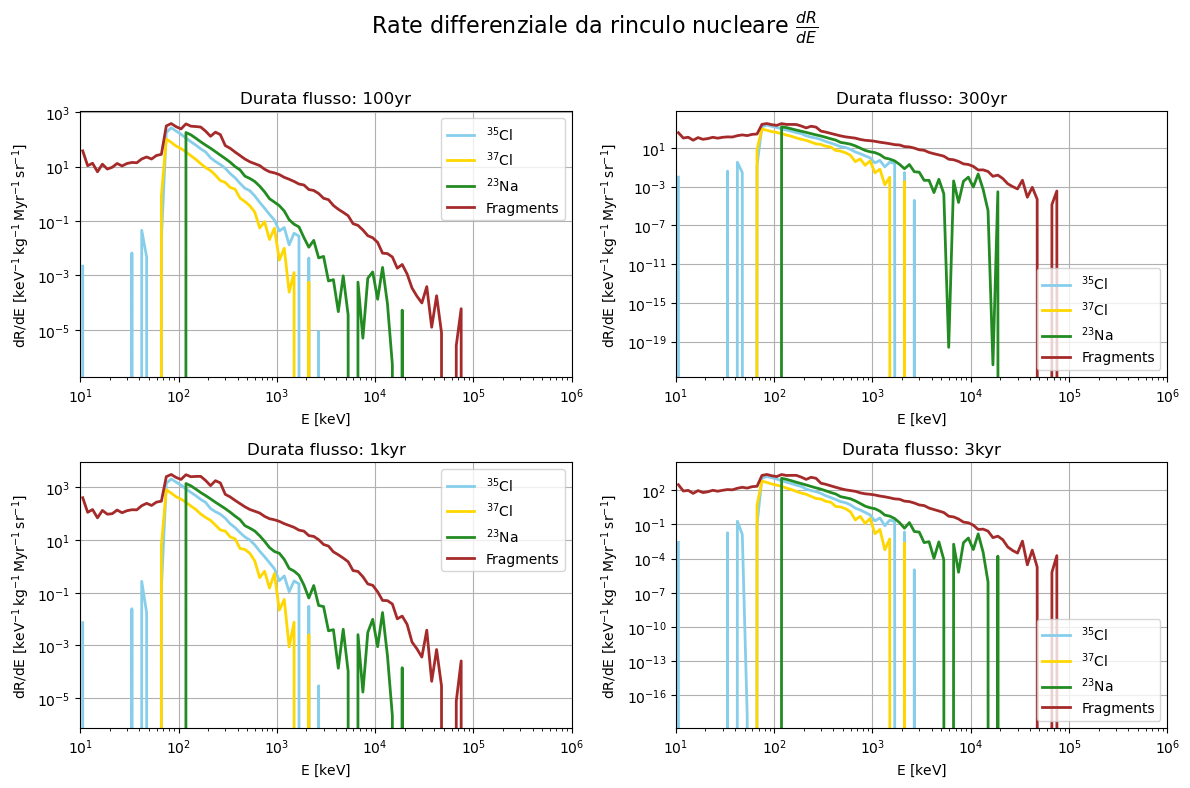

In [19]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV
time_exposure = 3450 * 365 * 24 * 60 * 60  # Tempo di esposizione in secondi 
label_time_fluxes = ["100yr", "300yr", "1kyr", "3kyr"]  # Nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [5e-5, 4.5e-4, 1.35e-3, 3.5e-3]  # Intervallo tra un flusso e l'altro in Myr

# Crea la figura e i subplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Rate differenziale da rinculo nucleare $\\frac{{dR}}{{dE}}$", fontsize=16)

for i, label in enumerate(label_time_fluxes):
    # Carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    # Crea un array di flussi interpolati
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y)  # Energia in GeV e flusso m-2*s-1*sr-1*GeV-1

    # Integra e calcola conteggi
    Num = Integration([flux_func], [time_fluxes[i]], time_exposure)  # Array somma delle energie di tutti i flussi, normalizzato al tempo totale
    Conta = Count(Num, Er)

    Er_width = np.diff(Er)  # Larghezza del bin
    Er_mid = Er[:-1] + Er_width / 2  # Punto medio del bin

    Frag = np.zeros(len(Er_mid))  # Array con tutti i punti medi dei bin di energia
    for k in range(len(Conta[4])):  # Conta[4]=lunghezza di nuclei
        for l in range(len(Er_mid)):
            Frag[l] += Conta[3][k][l]  # Somma i bin dei vari nuclei

    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')  # Interpolazione
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

    # Seleziona il subplot corrente
    ax = axs[i // 2, i % 2]

    # Disegna nel subplot corrente
    ax.loglog(Er_mid * 1e3, F35(Er_mid) * 1e-3 / (length * rho), label="$^{35}$Cl", linewidth=2, color='skyblue')
    ax.loglog(Er_mid * 1e3, F37(Er_mid) * 1e-3 / (length * rho), label="$^{37}$Cl", linewidth=2, color='gold')
    ax.loglog(Er_mid * 1e3, F23(Er_mid) * 1e-3 / (length * rho), label="$^{23}$Na", linewidth=2, color='forestgreen')
    ax.loglog(Er_mid * 1e3, Frag * 1e-3 / Er_width / (length * rho), label='Fragments', linewidth=2, color='brown')

    ax.set_xlabel("E [$\\mathrm{keV}$]")
    ax.set_ylabel("dR/dE [$\\mathrm{keV}^{-1}\\,\\mathrm{kg}^{-1}\\,\\mathrm{Myr}^{-1}\\,\\mathrm{sr}^{-1}$]")
    ax.set_xlim(1e1, 1e6)
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Durata flusso: {label}")

# Aggiusta gli spazi tra i subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Lascia spazio per il titolo generale
plt.show()


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

## $\frac{dR}{dx}$ sommando tutti i i-esimi nuclei, pesati, tramite la chain rule


In [18]:
import paleopy as paleopy
from paleopy import *

halite = paleopy.Mineral("Halite")

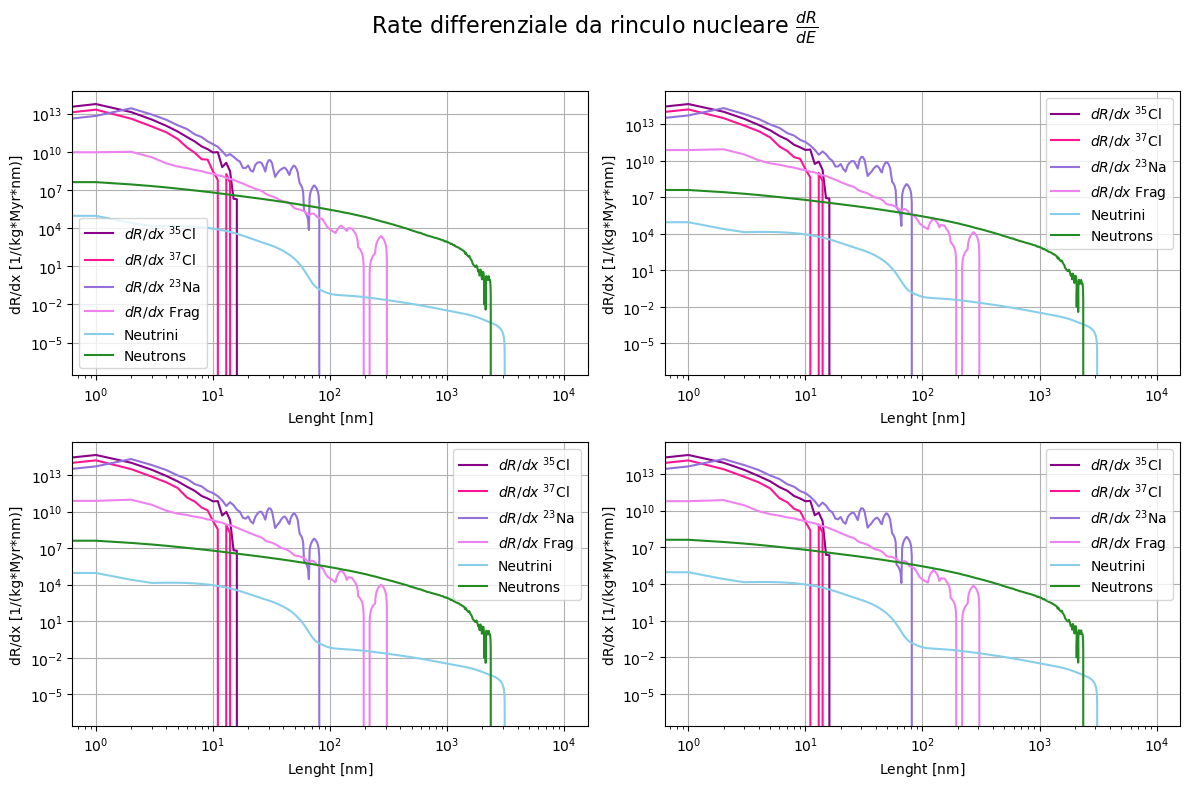

In [23]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV
time_exposure = 3450 * 365 * 24 * 60 * 60  # Tempo di esposizione in secondi 
label_time_fluxes = ["100yr", "300yr", "1kyr", "3kyr"]  # Nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [5e-5, 4.5e-4, 1.35e-3, 3.5e-3]  # Intervallo tra un flusso e l'altro in Myr

Na  = 6.022e23
tau = 6.45e3 #Myr #tempo di dimezzamento dell'U238
t   = 1.0     #Myr #durata dell'esposizione
U_frac=5e-6 #concentration of Uranium in halite
factor = 1e-5*(5.4e-7)*((U_frac)*Na*1e3/(238))/tau #numero di eventi di fissione normalizzati alla concentrazione di Uranio, rate di decadimento e BR


# Crea la figura e i subplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Rate differenziale da rinculo nucleare $\\frac{{dR}}{{dE}}$", fontsize=16)

for i, label in enumerate(label_time_fluxes):
    # Carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    # Crea un array di flussi interpolati
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y)  # Energia in GeV e flusso m-2*s-1*sr-1*GeV-1

    # Integra e calcola conteggi
    Num = Integration([flux_func], [time_fluxes[i]], time_exposure)  # Array somma delle energie di tutti i flussi, normalizzato al tempo totale
    Conta = Count(Num, Er)

    Er_width = np.diff(Er)  # Larghezza del bin
    Er_mid = Er[:-1] + Er_width / 2  # Punto medio del bin

    Frag = np.zeros(len(Er_mid))  # Array con tutti i punti medi dei bin di energia
    for k in range(len(Conta[4])):  # Conta[4]=lunghezza di nuclei
        for l in range(len(Er_mid)):
            Frag[l] += Conta[3][k][l]  # Somma i bin dei vari nuclei

    F35 = interp1d(Er_mid, factor*Conta[0] / Er_width, fill_value='extrapolate')  # Interpolazione
    F37 = interp1d(Er_mid, factor*Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, factor*Conta[2] / Er_width, fill_value='extrapolate')

    # Seleziona il subplot corrente
    ax = axs[i // 2, i % 2]

     #aggiungo il calcolo di dRdx
    z_bins=np.linspace(0,10000, 10000)
    y_values35 = halite.dRdx_modified(z_bins, Er_mid, F35(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
    y_values37 = halite.dRdx_modified(z_bins, Er_mid, F37(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
    y_values23 = halite.dRdx_modified(z_bins, Er_mid, F23(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
    y_valuesFrag = halite.dRdx_modified(z_bins, Er_mid, Frag*1e-3/Er_width/(length*rho)) #il terzo input è dRdE calcolato sopra
    y_nu = halite.dRdx_nu(z_bins)
    y_neutrons = halite.dRdx_neutrons(z_bins) 

    # Allinea le lunghezze se necessario
    if len(z_bins) != len(y_values35):
        min_len = min(len(z_bins), len(y_values35))
        z_bins = z_bins[:min_len]
        y_values = y_values35[:min_len]

    #plot sugli assi
    ax.loglog(z_bins, y_values35, label='$dR/dx$ $^{35}$Cl', color='darkmagenta')
    ax.loglog(z_bins, y_values37, label='$dR/dx$ $^{37}$Cl', color='deeppink')
    ax.loglog(z_bins, y_values23, label='$dR/dx$ $^{23}$Na', color='mediumpurple')
    ax.loglog(z_bins, y_valuesFrag, label='$dR/dx$ Frag', color='violet')
    ax.loglog(z_bins, y_nu, label='Neutrini', color='skyblue')
    ax.loglog(z_bins, y_neutrons, label='Neutrons', color='forestgreen')

    ax.set_xlabel("Lenght [$\\mathrm{nm}$]")
    ax.set_ylabel("dR/dx [1/(kg*Myr*nm)]")
    #ax.set_xlim(0, 1e3)
    #ax.set_ylim(1e-2, 1e9)
    ax.legend()
    ax.grid(True)

# Aggiusta gli spazi tra i subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Lascia spazio per il titolo generale
plt.show()
